👋 Bienvenido al Organizador de Escapadas IA
Por favor completá los siguientes datos usando SOLO números:


Seleccioná el medio de transporte:
1. Auto
2. Micro
3. Avión
4. Tren

Seleccioná el nivel de presupuesto:
1. Bajo → Opciones económicas, transporte público, hostels.
2. Medio → Balance entre costo y comodidad.
3. Medio-alto → Hoteles 3-4⭐, experiencias destacadas.
4. Alto → Lujo, experiencias premium.

Seleccioná el modo de viaje:
1. Exprímelo → Aprovechar al máximo cada hora.
2. Relax → Ritmo tranquilo, descansos largos.
3. Cultural → Museos, historia, arquitectura.
4. Gastronómico → Comidas y vinos locales.
5. Aventura → Deportes y excursiones.
6. Familiar → Opciones aptas para todas las edades.

¿Hay niños menores de 12 años en el grupo?
1. Sí
2. No

¿En qué temporada vas a viajar?
1. Alta (vacaciones, feriados largos, temporada turística)
2. Baja (resto del año)

=== Resumen de tu viaje ===
Destino: Punta Tombo
Medio de transporte: avión
Duración: 7 días, para 4 personas.
Lleg

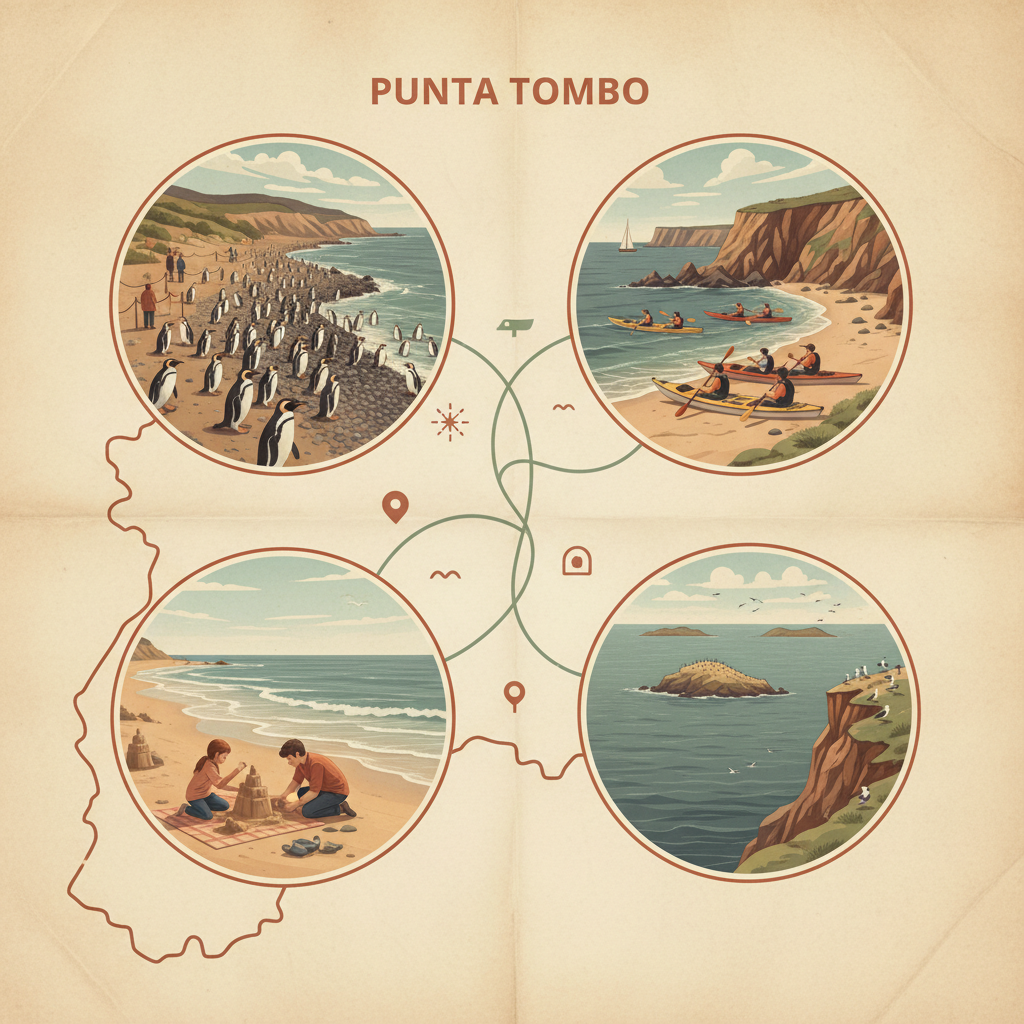

✅ Mapa generado → prompt5lite_Mapa.png

=== Generando Flyer ===


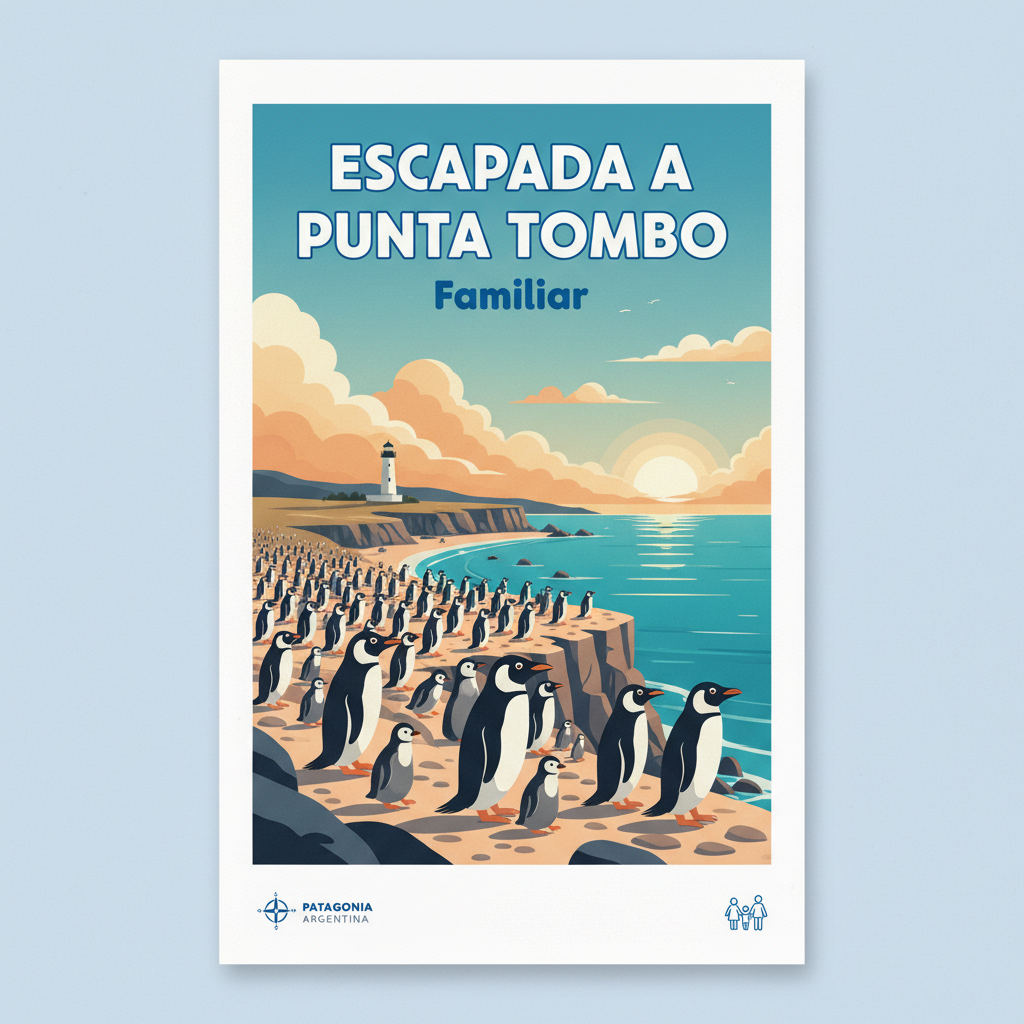

✅ Flyer generado → prompt5lite_Flyer.png


In [ ]:
from openai import OpenAI
import os, json
from dotenv import load_dotenv
from datetime import datetime
from PIL import Image
from io import BytesIO
import google.generativeai as genai  # Nano Banana
from IPython.display import display


# =======================
# Configuración API
# =======================
load_dotenv()
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
genai.configure(api_key=os.getenv("GOOGLE_API_KEY"))

# (PARCHE MÍNIMO) Modelo de imágenes Gemini
model_img = genai.GenerativeModel("gemini-2.5-flash-image-preview")

# =======================
# Variables globales para control de tokens
# =======================
acumulado_tokens = 0
acumulado_usd = 0.0

# =======================
# Helper JSON
# =======================
def safe_json_parse(raw_text: str):
    cleaned = raw_text.strip()
    if cleaned.startswith("```"):
        cleaned = cleaned.strip("`")
        cleaned = cleaned.replace("json\n", "").replace("json", "", 1).strip()
    try:
        return json.loads(cleaned)
    except:
        return {}

# =======================
# >>> Helpers de VALIDACIÓN (agregados)
# =======================
def pedir_texto_no_vacio(mensaje: str) -> str:
    while True:
        val = input(mensaje).strip()
        if val:
            return val
        print("⚠️ Ingresá un texto no vacío.")

def pedir_opcion_entera(mensaje: str, opciones_validas: range) -> int:
    while True:
        val = input(mensaje).strip()
        try:
            n = int(val)
            if n in opciones_validas:
                return n
            print(f"⚠️ Opción inválida. Elegí un número en {opciones_validas.start}–{opciones_validas.stop-1}.")
        except ValueError:
            print("⚠️ Ingresá un número entero válido.")

def pedir_entero_min(mensaje: str, minimo: int = 1) -> int:
    while True:
        val = input(mensaje).strip()
        try:
            n = int(val)
            if n >= minimo:
                return n
            print(f"⚠️ Ingresá un entero mayor o igual a {minimo}.")
        except ValueError:
            print("⚠️ Ingresá un número entero válido.")

def pedir_fecha_ddmmyyyy(mensaje: str) -> str:
    # Devuelve string en formato DD/MM/YYYY si es válido
    while True:
        s = input(mensaje).strip()
        try:
            datetime.strptime(s, "%d/%m/%Y")
            return s
        except ValueError:
            print("⚠️ Fecha inválida. Formato esperado: DD/MM/YYYY (ej: 05/09/2025).")

def pedir_hora_hhmm(mensaje: str) -> str:
    # Devuelve HHMM (4 dígitos) validando 00:00–23:59
    while True:
        s = input(mensaje).strip()
        if len(s) == 4 and s.isdigit():
            hh = int(s[:2]); mm = int(s[2:])
            if 0 <= hh <= 23 and 0 <= mm <= 59:
                return s
        print("⚠️ Hora inválida. Ingresá 4 dígitos HHMM (ej: 0830, 1300).")

# =======================
# Helper TOKENS
# =======================
def calcular_costo(response, nombre="Prompt", archivo="costos_totales.txt"):
    global acumulado_tokens, acumulado_usd

    if not hasattr(response, "usage"):
        return
    in_tokens = response.usage.prompt_tokens
    out_tokens = response.usage.completion_tokens
    total_tokens = response.usage.total_tokens
    in_price = in_tokens * 0.00000015
    out_price = out_tokens * 0.0000006
    costo_total = in_price + out_price

    acumulado_tokens += total_tokens
    acumulado_usd += costo_total

    with open(archivo, "a", encoding="utf-8") as f:
        f.write(
            f"{nombre} → Tokens usados: {total_tokens} "
            f"(entrada={in_tokens}, salida={out_tokens}), "
            f"USD {costo_total:.6f}\n"
        )

# 👉 Nuevo: cálculo para imágenes
def calcular_costo_imagen(nombre="Imagen", archivo="costos_totales.txt", costo_usd=0.04):
    global acumulado_usd
    acumulado_usd += costo_usd
    with open(archivo, "a", encoding="utf-8") as f:
        f.write(f"{nombre} → Costo fijo por imagen: USD {costo_usd:.6f}\n")

def guardar_resumen_tokens(archivo="costos_totales.txt"):
    with open(archivo, "a", encoding="utf-8") as f:
        f.write("\n=== RESUMEN TOTAL ===\n")
        f.write(f"Tokens totales consumidos: {acumulado_tokens}\n")
        f.write(f"Costo total estimado: USD {acumulado_usd:.6f}\n")


# =======================
# Recolección de datos
# =======================
print("👋 Bienvenido al Organizador de Escapadas IA")
print("Por favor completá los siguientes datos usando SOLO números:\n")

# >>> Validación: texto no vacío
destino = pedir_texto_no_vacio("Destino del viaje (texto libre): ")

# Transporte
print("\nSeleccioná el medio de transporte:")
transportes = {
    1: "auto",
    2: "micro",
    3: "avión",
    4: "tren"
}
for k, v in transportes.items():
    print(f"{k}. {v.capitalize()}")

# >>> Validación: opción 1–4
transporte_op = pedir_opcion_entera("Seleccione Medio de Transporte: ", range(1, 5))
transporte = transportes.get(transporte_op, "auto")

# Personas
# >>> Validación: entero >= 1
cant_personas = pedir_entero_min("\nCantidad de personas: ", minimo=1)

# Fechas y horarios (con reintento si el rango es inválido)
while True:
    # >>> Validación: fecha
    fecha_inicio = pedir_fecha_ddmmyyyy("\nFecha de inicio (ej: 05/09/2025): ")
    # >>> Validación: hora HHMM
    hora_llegada = pedir_hora_hhmm("Hora de llegada (HHMM, ej: 1300 para las 13:00): ")
    # Mantiene lógica original de conversión
    hora_llegada = f"{hora_llegada[:2]}:{hora_llegada[2:]}"  # convierte a HH:MM

    fecha_regreso = pedir_fecha_ddmmyyyy("\nFecha de regreso (ej: 07/09/2025): ")
    hora_regreso = pedir_hora_hhmm("Hora de regreso (HHMM, ej: 0830 para las 8:30): ")
    hora_regreso = f"{hora_regreso[:2]}:{hora_regreso[2:]}"
    try:
        dt_inicio = datetime.strptime(f"{fecha_inicio} {hora_llegada}", "%d/%m/%Y %H:%M")
        dt_regreso = datetime.strptime(f"{fecha_regreso} {hora_regreso}", "%d/%m/%Y %H:%M")
        if dt_regreso <= dt_inicio:
            print("⚠️ La fecha/hora de regreso debe ser posterior a la de inicio. Intentá nuevamente.")
            continue
        break
    except ValueError:
        # Por si algo raro escapa a los validadores
        print("⚠️ Fecha u hora inválida. Intentá nuevamente.")

cant_dias = (dt_regreso.date() - dt_inicio.date()).days + 1
if cant_dias < 1:
    # Con las validaciones anteriores no debería ocurrir, pero mantenemos tu chequeo original
    raise ValueError("⚠️ La fecha de regreso debe ser posterior a la fecha de inicio.")

# Presupuesto
print("\nSeleccioná el nivel de presupuesto:")
presupuestos = {
    1: "bajo",
    2: "medio",
    3: "medio-alto",
    4: "alto"
}
print("1. Bajo → Opciones económicas, transporte público, hostels.")
print("2. Medio → Balance entre costo y comodidad.")
print("3. Medio-alto → Hoteles 3-4⭐, experiencias destacadas.")
print("4. Alto → Lujo, experiencias premium.")
# >>> Validación: opción 1–4
presupuesto_op = pedir_opcion_entera("Seleccione el Nivel de Presupuesto: ", range(1, 5))
presupuesto = presupuestos.get(presupuesto_op, "medio")

# Modos de viaje
print("\nSeleccioná el modo de viaje:")
modos = {
    1: ("Exprímelo", "Aprovechar al máximo cada hora."),
    2: ("Relax", "Ritmo tranquilo, descansos largos."),
    3: ("Cultural", "Museos, historia, arquitectura."),
    4: ("Gastronómico", "Comidas y vinos locales."),
    5: ("Aventura", "Deportes y excursiones."),
    6: ("Familiar", "Opciones aptas para todas las edades.")
}
for k, v in modos.items():
    print(f"{k}. {v[0]} → {v[1]}")
# >>> Validación: opción 1–6
modo_op = pedir_opcion_entera("Seleccione el Modo de Viaje: ", range(1, 7))
modo_viaje = modos.get(modo_op, modos[1])[0]

# Niños si es Familiar
ninos_menores_12 = False
if modo_viaje == "Familiar":
    print("\n¿Hay niños menores de 12 años en el grupo?")
    print("1. Sí")
    print("2. No")
    # >>> Validación: opción 1–2
    resp = pedir_opcion_entera("¿Hay niños menores de 12 años en el grupo?: ", range(1, 3))
    ninos_menores_12 = True if resp == 1 else False

# Temporada manual
print("\n¿En qué temporada vas a viajar?")
print("1. Alta (vacaciones, feriados largos, temporada turística)")
print("2. Baja (resto del año)")
# >>> Validación: opción 1–2
temp_op = pedir_opcion_entera("¿En qué temporada vas a viajar?: ", range(1, 3))
temporada = "alta" if temp_op == 1 else "baja"

# =======================
# Resumen inicial
# =======================
print("\n=== Resumen de tu viaje ===")
print(f"Destino: {destino}")
print(f"Medio de transporte: {transporte}")
print(f"Duración: {cant_dias} días, para {cant_personas} personas.")
print(f"Llegada: {fecha_inicio} a las {hora_llegada}")
print(f"Regreso: {fecha_regreso} a las {hora_regreso}")
print(f"Presupuesto estimado: {presupuesto}")
print(f"Modo de viaje seleccionado: {modo_viaje}")
if modo_viaje == "Familiar":
    print(f"¿Viajan niños menores de 12 años?: {'Sí' if ninos_menores_12 else 'No'}")
print(f"Temporada: {temporada.upper()}")

# =======================
# Prompt A - Intake JSON
# =======================
intake_prompt = f"""
Sos un organizador de viajes.
Devolvé SOLO un JSON válido.

JSON esperado:
{{
  "param": {{
    "dest": "{destino}",
    "transporte": "{transporte}",
    "dias": {cant_dias},
    "pers": {cant_personas},
    "presupuesto": "{presupuesto}",
    "modo": "{modo_viaje}",
    "fecha_inicio": "{fecha_inicio}",
    "hora_llegada": "{hora_llegada}",
    "fecha_regreso": "{fecha_regreso}",
    "hora_regreso": "{hora_regreso}",
    "ninos_menores_12": {str(ninos_menores_12).lower()},
    "temporada": "{temporada}"
  }}
}}
"""

intake_response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Respondé SOLO con JSON válido y breve."},
        {"role": "user", "content": intake_prompt}
    ],
    temperature=0.2
)

calcular_costo(intake_response, "Prompt A - Intake")
raw_intake = intake_response.choices[0].message.content
intake_json = safe_json_parse(raw_intake)

print("\n=== Intake JSON ===")
print(json.dumps(intake_json, indent=2, ensure_ascii=False))

# =======================
# Prompt A - Itinerario
# =======================
itinerario_prompt = f"""
Usá este JSON:

{json.dumps(intake_json, indent=2, ensure_ascii=False)}

Generá un itinerario detallado de {cant_dias} días.

Formato:
Día N - Zona
09:00-11:00 Actividad
[Si corresponde: (traslado: XX min medio)]
11:15-13:00 Actividad
[Si corresponde: (traslado: XX min medio)]
13:15-14:30 Almuerzo (2 opciones)
[Si corresponde: (traslado: XX min medio)]
15:00-17:00 Actividad
[Si corresponde: (traslado: XX min medio)]
17:15-19:00 Actividad
20:00 Cena (2 opciones)

Reglas adicionales:
- Mostrá tiempos de traslado SOLO cuando cambie el lugar de la actividad.
- No repitas traslado si la siguiente actividad ocurre en el mismo sitio.
- Si el modo de viaje es "Familiar" y "ninos_menores_12" es true:
  - Incluí actividades adaptadas y marcá con 👶.
  - Si alguna actividad no es apta para menores o es muy exigente, marcala con ⚠️ y proponé una "Actividad alternativa" en ese mismo día y horario.
- Si el modo de viaje es "Familiar" pero "ninos_menores_12" es false:
  - NO incluyas actividades adaptadas para niños.
- Considerá la temporada:
  - Si es ALTA → recomendá reservas anticipadas, horarios tempranos y opciones alternativas por alta demanda.
  - Si es BAJA → advertí sobre posibles cierres o menor disponibilidad de actividades.
- Al final de cada día, incluir un breve resumen con tips.
"""

itinerario_response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Devolvé solo itinerario en texto limpio."},
        {"role": "user", "content": itinerario_prompt}
    ],
    temperature=0.4
)

calcular_costo(itinerario_response, "Prompt A - Itinerario")
content = itinerario_response.choices[0].message.content

print("\n=== Itinerario generado ===")
print(content)

with open("itinerario_final.txt", "w", encoding="utf-8") as f:
    f.write(content)

# =======================
# Prompt QA - Control de calidad (agrupado y visual mejorado)
# =======================
qa_prompt = f"""
Revisá el siguiente itinerario y generá un JSON con advertencias relevantes agrupadas por día.

Itinerario:
{content}

Devolvé SOLO un JSON con este formato:
{{
  "alertas": {{
    "Día 2": [
      "Actividad X puede no ser apta para niños",
      "Traslado mayor a 60 minutos"
    ],
    "Día 5": [
      "Actividad Y puede ser excesiva"
    ]
  }}
}}

Reglas:
- Agrupá todas las advertencias bajo el día correspondiente.
- Marcá traslados mayores a 60 minutos.
- Detectá jornadas con exceso de actividades según el modo elegido.
- Señalá actividades no aptas para niños si hay menores de 12 años.
- Si no hay niños, no incluyas esas advertencias.
- Si la temporada es "alta" → incluir advertencia de "Reserva anticipada".
- Si la temporada es "baja" → incluir advertencia de "Atracciones cerradas por estacionalidad".
- No incluyas advertencias de temporada que no correspondan.
- Si no hay alertas para un día, no incluyas ese día en el JSON.
"""

qa_response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Actuá como auditor de itinerarios. Respondé SOLO con JSON válido."},
        {"role": "user", "content": qa_prompt}
    ],
    temperature=0.2
)

calcular_costo(qa_response, "Prompt QA - Auditoría")
qa_json = safe_json_parse(qa_response.choices[0].message.content)

print("\n=== QA del itinerario ===")
for dia, alertas in qa_json.get("alertas", {}).items():
    print(f"\n📅 {dia}")
    print("-" * (len(dia) + 4))
    for alerta in alertas:
        icono = "⚠️"
        if "niños" in alerta.lower():
            icono = "👶"
        elif "traslado" in alerta.lower():
            icono = "🕒"
        elif "presupuesto" in alerta.lower():
            icono = "💸"
        elif "reserva" in alerta.lower() or "estacionalidad" in alerta.lower():
            icono = "📅"
        print(f"{icono} {alerta}")
    print("-" * 40)

# =======================
# Extracción de lugares y servicios
# =======================
lugares = []
palabras_clave = [
    "hotel", "restaurante", "bodega", "actividad", "excursión",
    "remis", "taxi", "auto de alquiler", "transfer", "museo",
    "café", "bar", "parque", "mercado", "zoológico", "plaza"
]

for line in content.splitlines():
    texto = line.strip()
    if not texto:
        continue
    if any(palabra in texto.lower() for palabra in palabras_clave):
        lugares.append(texto)
    elif any(palabra.istitle() for palabra in texto.split()):
        lugares.append(texto)

print("\n=== Lugares y servicios detectados en el itinerario ===")
print(lugares)

with open("lugares.json", "w", encoding="utf-8") as f:
    json.dump(lugares, f, indent=2, ensure_ascii=False)

# =======================
# Extraer puntos clave del itinerario
# =======================
puntos = []
for line in content.splitlines():  # (PARCHE) usar 'content'
    if any(keyword in line.lower() for keyword in ["actividad", "almuerzo", "cena", "tour", "visita", "excursión", "paseo"]):
        puntos.append(line.strip())
lista_puntos = " | ".join(puntos)

# =======================
# (PARCHE) Subtítulo del flyer
# =======================
intereses = modo_viaje  # reutiliza la selección del usuario

# =======================
# Prompts de Imagen (mapa dinámico + flyer)
# =======================
prompts_img = {
    "Mapa": f"""
Mapa turístico ilustrado estilo vintage de {destino} basado en el itinerario, con textura de papel antiguo y paleta cálida (beige, terracota, verdes suaves).
Base: contorno simplificado de {destino} o del área de viaje, con líneas curvas que conectan varios círculos grandes.
Dentro de cada círculo, mostrar **pequeñas escenas realistas del destino** (sin texto), seleccionadas a partir del itinerario y estos puntos clave:
{lista_puntos}

Reglas para elegir las 4 escenas (adaptadas a {destino}):
- Si {destino} es de montaña/lago → usar: cordillera/cumbres, lago/valle, ciclista o senderismo local, bosque/parque típico.
- Si es de costa → usar: playa/olas, puerto/muelle, embarcación local, acantilado o dunas.
- Si es urbano → usar: arquitectura icónica/plaza central, mercado o café típico, parque urbano, actividad cultural.
- Si es zona vitivinícola o gastronómica → incluir viñedos con racimos, copa/bodega (realista), plato regional.
- Si hay nieve → incluir escena invernal (centro de ski o paisaje nevado).
- Priorizar escenas mencionadas en el itinerario; si alguna falta, sustituir por el hito natural/cultural más representativo de {destino}.
- Estilo híbrido: mapa e iconografía mínima ilustrada + círculos con escenas **realistas** (pintura/foto-look). 
- **No agregar texto ni etiquetas en ningún lugar**.
Formato: horizontal 16:9, PNG, composición limpia y nítida, coherente y equilibrada.
""",

    "Flyer": f"""
Flyer turístico 16:9 para {destino}, estilo travel-poster moderno.
Título: 'Escapada a {destino}'.
Subtítulo: {intereses}.
Imagen icónica del lugar, composición limpia, margen seguro para texto.
Devuelve únicamente la imagen en PNG.
"""
}

# =======================
# Función para generar imágenes
# =======================
def generar_imagenes_lite(prompts: dict, prefix="prompt5lite"):
    for nombre, p in prompts.items():
        try:
            print(f"\n=== Generando {nombre} ===")
            # (PARCHE) llamada al modelo Gemini
            response_img = model_img.generate_content(p)
            saved = False
            # Mismo esquema de extracción usado anteriormente
            if hasattr(response_img, "candidates") and response_img.candidates:
                parts = response_img.candidates[0].content.parts
                for part in parts:
                    if hasattr(part, "inline_data") and part.inline_data:
                        img = Image.open(BytesIO(part.inline_data.data))
                        img.save(f"{prefix}_{nombre}.png")
                        display(img)   # Muestra la imagen en la celda del notebook
                        print(f"✅ {nombre} generado → {prefix}_{nombre}.png")
                        calcular_costo_imagen(f"Imagen {nombre}")
                        saved = True
                        break
            if not saved:
                print(f"⚠️ No se generó imagen para {nombre}. Gemini no devolvió inline_data")
        except Exception as e:
            print(f"❌ Error generando {nombre}: {e}")


# =======================
# Prompt C - Simulación de datos de contacto
# =======================
prompt_contactos = f"""
A partir de la siguiente lista de lugares y servicios detectados en el itinerario:

{json.dumps(lugares, indent=2, ensure_ascii=False)}

Simulá que buscás en la web sus datos de contacto.

Devolvé SOLO un JSON con este formato:
[
  {{
    "nombre": "Nombre del lugar o empresa",
    "tipo": "hotel | restaurante | bodega | actividad | excursión | transporte",
    "web": "URL ficticia o realista",
    "telefono": "Teléfono ficticio con código de país",
    "email": "Email ficticio con formato válido"
  }}
]

Reglas:
- Si aparecen hoteles, restaurantes, bodegas, actividades o excursiones → devolvé contactos de esos lugares.
- Si en el itinerario figuran medios de transporte local como autos de alquiler, remises, taxis o transfers → incluí también empresas proveedoras de ese servicio en la zona del destino.
- Los datos deben ser plausibles y consistentes con Argentina.
"""

contactos_response = openai_client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {"role": "system", "content": "Respondé SOLO con JSON válido."},
        {"role": "user", "content": prompt_contactos}
    ],
    temperature=0.4
)

calcular_costo(contactos_response, "Prompt C - Contactos")
raw_contactos = contactos_response.choices[0].message.content
contactos_json = safe_json_parse(raw_contactos)

with open("contactos.json", "w", encoding="utf-8") as f:
    json.dump(contactos_json, f, indent=2, ensure_ascii=False)

print("\n=== Lugares y servicios con datos de contacto simulados ===")
for lugar in contactos_json:
    print(f"📍 {lugar['nombre']} ({lugar['tipo']})")
    print(f"   🌐 Web: {lugar['web']}")
    print(f"   📞 Tel: {lugar['telefono']}")
    print(f"   ✉️  Email: {lugar['email']}")
    print("-" * 50)

# =======================
# Generar imágenes
# =======================
generar_imagenes_lite(prompts_img, prefix="prompt5lite")

# =======================
# Guardar resumen total de tokens
# =======================
guardar_resumen_tokens()
